In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import os
import pickle
from importlib import reload

import torch
import matplotlib
import numpy as np
import pandas as pd
import sciplots as plots
import matplotlib.pyplot as plt
import netloader.networks as nets
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sciplots.utils import label_change
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netloader.data import loader_init
from netloader import transforms

from src import main
from src.utils import data
from src.utils import analysis
from src.utils.utils import open_config, overlap

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(data)
reload(analysis)
reload(main)

import sciplots as plots
from src.utils.data import DarkDataset
from src.utils import analysis, plot_config

In [3]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = os.path.join(config['output']['plots-directory'], 'final_plots')
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)

In [4]:
def mean_ste_index(means, stes, idxs, fixed_idxs, dim, min):
    new_means = []
    new_stes = []

    for idx, mean, ste in zip(idxs, means[*fixed_idxs].swapaxes(0, dim), stes[*fixed_idxs].swapaxes(0, dim)):
        min_idx = np.argmin(mean[idx]) if min else np.argmax(mean[idx])
        new_means.append(mean[idx][min_idx])
        new_stes.append(ste[idx][min_idx])

    return new_means, new_stes


def merge_plots(plot_base, plot_append):
    plot_base._y_data = list(plot_base._y_data) if isinstance(plot_base._y_data, np.ndarray) else plot_base._y_data

    for line, poly in zip(plot_append.plots[plot_append.axes][::2], plot_append.plots[plot_append.axes][1::2]):
        line.remove()
        poly.remove()
        plot_append.plots[plot_append.axes].remove(line)
        plot_append.plots[plot_append.axes].remove(poly)

        line.set_ydata(line.get_ydata() / np.trapezoid(line.get_ydata(), np.log10(line.get_xdata())))
        verts = poly.get_paths()[0].vertices
        verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
        poly.set_verts([verts])

        plot_append.axes.add_line(line)
        plot_append.axes.add_collection(poly)
        plot_append.plots[plot_append.axes].append(line)
        plot_append.plots[plot_append.axes].append(poly)

    for line in plot_append.plots[plot_append.axes][::2]:
        plot_base.plots[plot_base.axes].append(
            plot_base.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.4, ls='-')[0])
        plot_base._data.append(line.get_xdata())
        plot_base._y_data.append(line.get_ydata())

    plot_base.axes.set_xlim(
        min([min(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]),
        max([max(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]))


def axis_range_ticks(axis):
    range_ = axis.get_ylim()
    ticks = axis.get_yticks()
    ticks = ticks[(range_[0] < ticks) & (ticks < range_[1])]

    if axis.get_yscale() == 'log':
        return np.log10(range_), np.log10(ticks)
    return np.array(range_), np.array(ticks)


def sync_twin_axes(axis1, axis2):
    ax1_range, ax1_ticks = axis_range_ticks(axis1)
    ax2_range, ax2_ticks = axis_range_ticks(axis2)
    lcm = np.lcm(len(ax1_ticks), len(ax2_ticks))

    norm_ax1_ticks = (ax1_ticks - ax1_range[0]) / (ax1_range[1] - ax1_range[0])
    norm_ax2_ticks = (ax2_ticks - ax2_range[0]) / (ax2_range[1] - ax2_range[0])
    norm_ax1_step = (norm_ax1_ticks[1] - norm_ax1_ticks[0]) * len(ax1_ticks) / lcm
    norm_ax2_step = (norm_ax2_ticks[1] - norm_ax2_ticks[0]) * len(ax2_ticks) / lcm
    norm_ax1_grid = np.arange(norm_ax1_ticks[0] - norm_ax1_step, norm_ax1_ticks[-1] + 2 * norm_ax1_step, norm_ax1_step)
    norm_ax2_grid = np.arange(norm_ax2_ticks[0] - norm_ax2_step, norm_ax2_ticks[-1] + 2 * norm_ax2_step, norm_ax2_step)

    diff = (norm_ax2_grid[None] - norm_ax1_grid[:, None]).flatten()
    idx = np.argmin(np.abs(diff))
    scale = norm_ax1_step / norm_ax2_step
    targets = norm_ax2_grid[idx % len(norm_ax2_grid)] + (
            norm_ax2_ticks - norm_ax2_grid[idx % len(norm_ax2_grid)]
    ) * scale - diff[idx]
    new_scale = (ax2_ticks[-1] - ax2_ticks[0]) / targets[-1] / (1 - targets[0] / targets[-1])
    offset = ax2_ticks[0] - targets[0] * new_scale
    axis2.set_ylim(10 ** (np.array([0, 1]) * new_scale + offset))

# DARKSKIES-0.1 Unknown

In [24]:
torch.manual_seed(0)
np.random.seed(0)
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'darkskies_cdm',
        'darkskies_0.1',
        'darkskies_0.2',
    ],
    [
        # 'darkskies_0.1',
    ],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
# labels = np.array([r'$\textsc{' + label + '}$' if label.lower() != 'noise' else label for label in labels])
dataset.high_dim.shape

(25200, 3, 100, 100)

In [30]:
batch_num = 49
data = analysis.batch_train_summary(batch_num, '../data/')

if isinstance(data['nets'].flatten()[0], str):
    data['nets'] = data['nets'].astype(object)
    for shape in np.ndindex(data['nets'].shape):
        data['nets'][*shape] = torch.load(data['nets'][*shape], weights_only=False, map_location='cpu')

data['nets'].shape

(1, 4, 5)

In [87]:
with open(f'../data/temp_batch_predictions_{batch_num}.pkl', 'rb') as file:
    predictions = pickle.load(file)

In [22]:
dataset.high_dim.shape

torch.Size([25200, 1, 100, 100])

In [25]:
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    data['nets'],
    dataset,
    idxs=dataset.idxs[np.isin(dataset.extra['ids'], data['nets'][0, -1, 0].idxs)],
)

Loader Dataset Lengths: [20160, 5040]
Prediction time: 2.479e+00 s
Prediction time: 2.185e+00 s
Prediction time: 2.183e+00 s
Prediction time: 2.183e+00 s
Prediction time: 2.182e+00 s
Loader Dataset Lengths: [20160, 5040]
Prediction time: 2.182e+00 s
Prediction time: 2.185e+00 s
Prediction time: 2.185e+00 s
Prediction time: 2.186e+00 s
Prediction time: 2.187e+00 s
Loader Dataset Lengths: [20160, 5040]
Prediction time: 2.182e+00 s
Prediction time: 2.195e+00 s
Prediction time: 2.187e+00 s
Prediction time: 2.195e+00 s
Prediction time: 2.198e+00 s
Loader Dataset Lengths: [20160, 5040]
Prediction time: 2.195e+00 s
Prediction time: 2.197e+00 s
Prediction time: 2.184e+00 s
Prediction time: 2.182e+00 s
Prediction time: 2.179e+00 s


In [ ]:
with open(f'../data/temp_batch_predictions_{batch_num}.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [89]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    data['nets'],
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 4, 5, 9), (1, 4, 9, 500), (1, 4, 500), (1, 4, 9, 500), (7, 1, 4, 9))

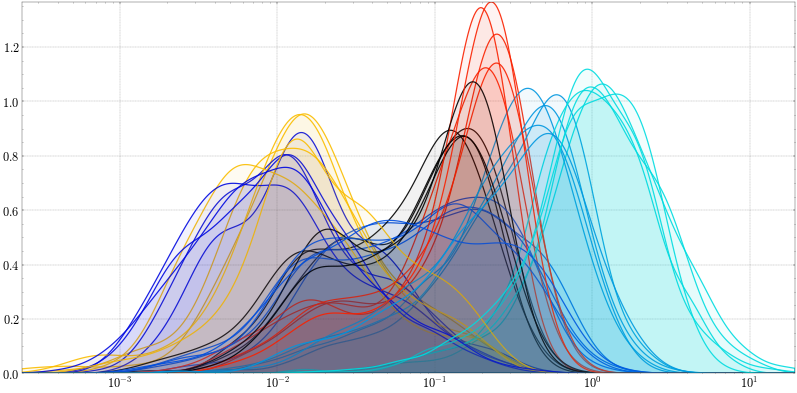

In [90]:
idx = (-1, -1)
# sim_idx = np.arange(len(labels))
sim_idx = np.array([0] + list(range(3, len(labels))))
colours = np.array(plot_config.FLAMINGO[:1] + plot_config.BAHAMAS[:1] + ['k'] + plot_config.BAHAMAS[1:2] + plot_config.FLAMINGO[2:] + plot_config.BAHAMAS[2:])
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

,50%,5%,16%,84%,95%,-,+
DARKSKIES-0,0.01312,0.00670,0.00885,0.01991,0.02691,0.00427,0.00679
BAHAMAS-0,0.01041,0.00375,0.00557,0.01579,0.02134,0.00484,0.00539
DARKSKIES-0.1,0.14271,0.04915,0.09625,0.19288,0.23216,0.04646,0.05017
BAHAMAS-0.1,0.11320,0.01945,0.03722,0.23216,0.32865,0.07597,0.11896
DARKSKIES-0.2,0.21657,0.13625,0.16784,0.27304,0.31377,0.04873,0.05647
BAHAMAS-0.3,0.44417,0.20676,0.29270,0.62878,0.75684,0.15148,0.18461
BAHAMAS-1,1.07140,0.61438,0.75684,1.62588,2.09790,0.31456,0.55448


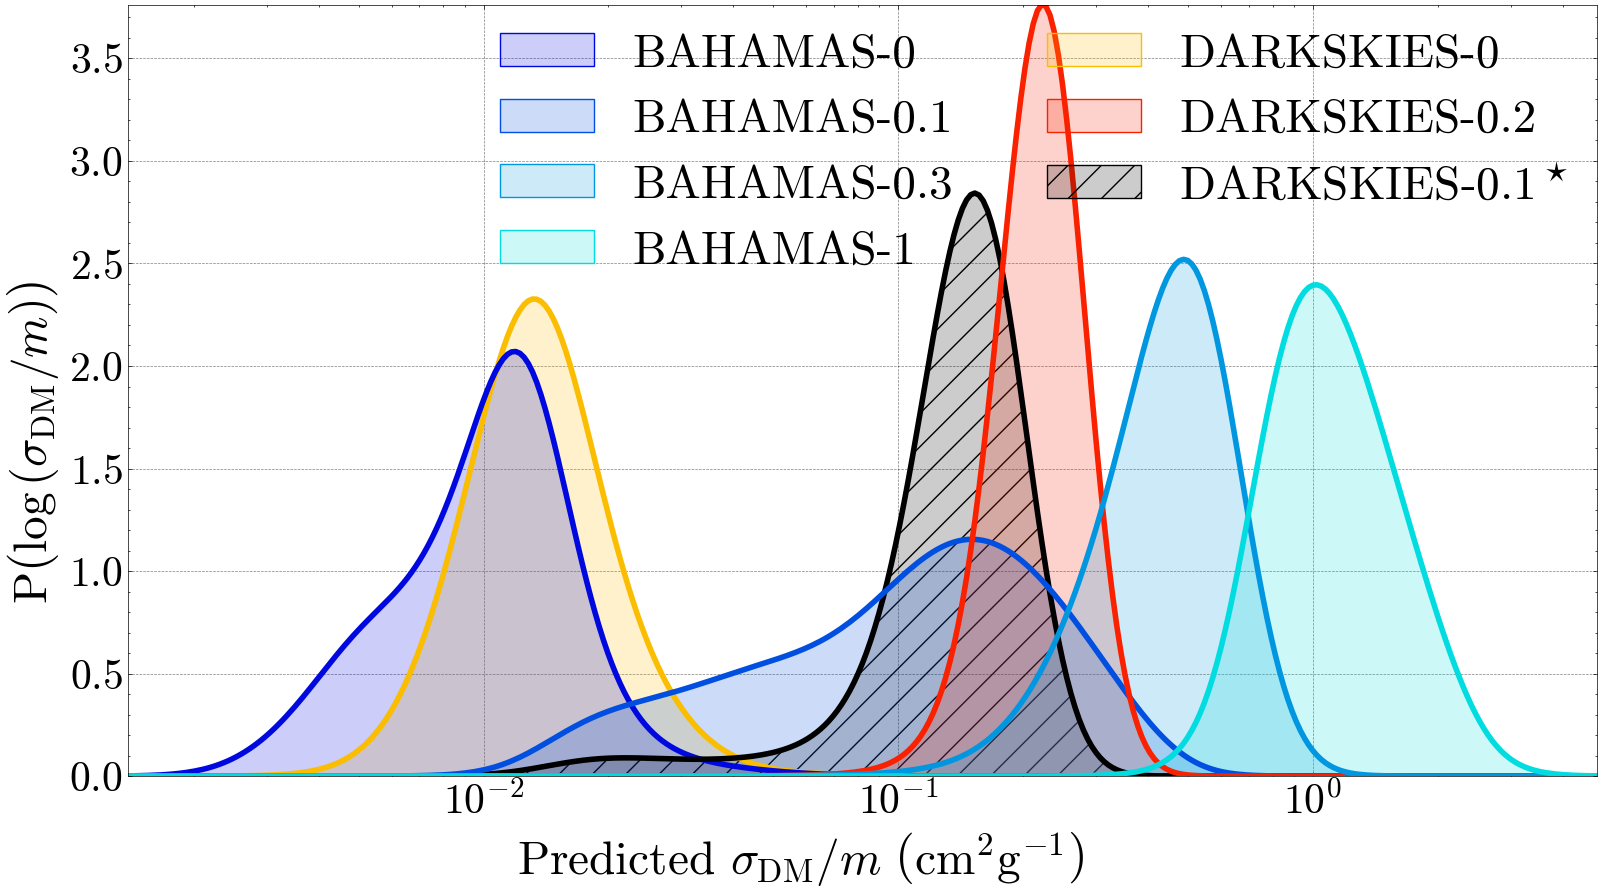

In [91]:
new_labels = labels[sim_idx].copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
styles = np.array(['-'] * len(new_labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(new_labels), dtype=object)
hatches[colours == 'k'] = '/'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx][sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    labels=new_labels,
    colours=colours,
    # styles=styles,
    styles='-',
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=2,
    loc='upper right',
    label_permute=[1, 3, 5, 6, 0, 4, 2],
    frameon=False,
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx, sim_idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='darkskies-0.1_distribution')
pd.DataFrame(quantiles[:, *idx, sim_idx].swapaxes(0, 1), index=labels[sim_idx],
             columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

In [92]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(data_pred['latent'].shape[:-2]):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)

overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(overlaps.shape):
    overlaps[*shape] = overlap(*proj_vecs[*shape])

overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])

proj_vecs.shape, overlap_means.shape

((1, 4, 5, 9, 8, 2), (1, 4, 9, 8))

,DARKSKIES-0,BAHAMAS-0,BAHAMAS-0.1,DARKSKIES-0.2,BAHAMAS-0.3,BAHAMAS-1
Mean,57.81,0.0,0.0,70.49,0.0,0.0
STE,0.90,0.0,0.0,1.31,0.0,0.0


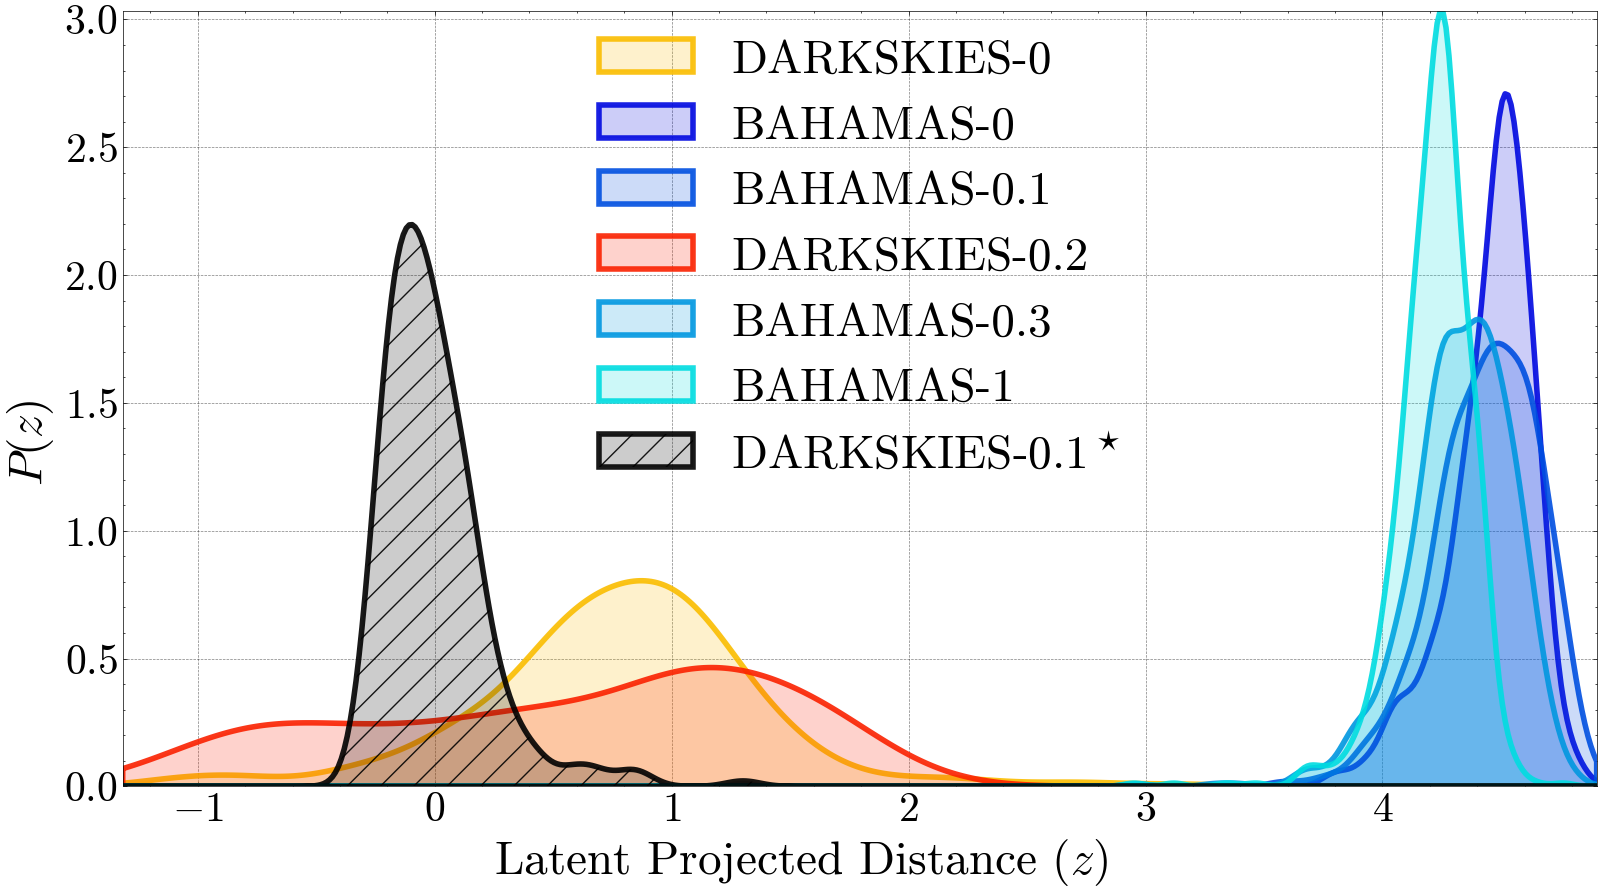

In [93]:
idx = (0, -1)
mmd_idx = 2
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]

plot = plots.PlotDistribution(
    [*sub_proj_vecs[:, 1], sub_proj_vecs[1, 0]],
    bins=500,
    y_axes=True,
    density=True,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(np.array(colours)[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(new_labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(new_labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    loc='upper center',
)
pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100

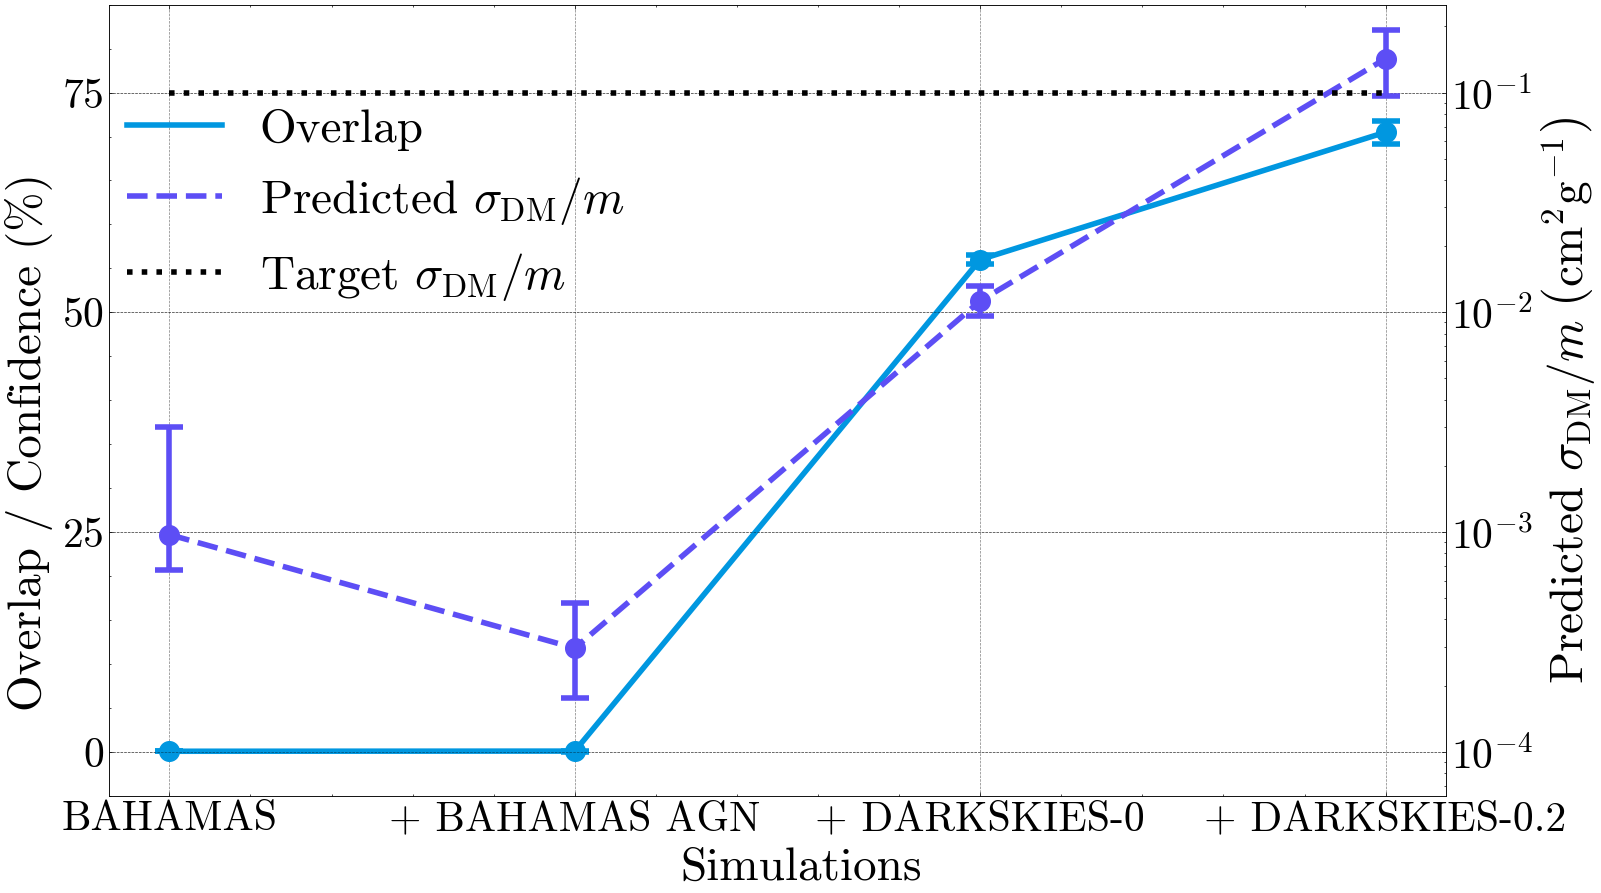

In [94]:
idxs = [[3, -4, -2, -1], [1, 2, 3, -4, -2, -1], [0, 1, 2, 3, -4, -2, -1], slice(None)]
fixed_idxs = [0, slice(None), 4]
y_data = np.array(mean_ste_index(
    overlap_means,
    overlap_stes,
    idxs,
    fixed_idxs,
    dim=0,
    min=False,
))

plot = plots.PlotPlots(
    np.array(['BAHAMAS', '+ BAHAMAS AGN', '+ DARKSKIES-0', '+ DARKSKIES-0.2']),
    [y_data[0] * 100] * 2,
    x_label='Simulations',
    y_label='Overlap / Confidence (%)',
    labels=['Overlap', ''],
    styles=['-', 'o'],
    y_error=[y_data[1] * 100, None],
    colours=plot_config.BAHAMAS[2:3] * 2,
    cap_size=10,
    line_width=4,
    eline_width=4,
    alpha_marker=1,
    axis=True,
    frameon=False,
    cols=1,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    loc=(0, 0.6),
)
plot.plot_twin_data(
    [quantiles[0, 0, :, fixed_idxs[-1]]] * 2 + [np.ones(y_data.shape[1]) * 0.1],
    y_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2 g^{-1}\right)$',
    labels=[r'Predicted $\sigma_{\rm DM}/m$', '', r'Target $\sigma_{\rm DM}/m$'],
    styles=['--', 'o', ':'],
    log_y=True,
    colours=plot_config.BAHAMAS_AGN[:1] * 2 + ['k'],
    x_data=np.array(['BAHAMAS', '+ BAHAMAS AGN', '+ DARKSKIES-0', '+ DARKSKIES-0.2']),
    y_error=[quantiles[-2:, 0, :, fixed_idxs[-1]], None, None],
)
plot.set_axes_pad(pad=0.05)
plot.axes.set_yticks([0, 25, 50, 75])
plot.axes.set_ylim(-5, 85)
list(plot.plots.keys())[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
list(plot.plots.keys())[1].set_ylim(8e-5, 2e-1)
sync_twin_axes(plot.axes, list(plot.plots.keys())[1])
plot.savefig(plots_dir, name='darkskies-0.1_prediction_overlap')